## Линейная регрессия

Давайте посмотрим, как строить линейную регрессию и анализировать ее качество.

In [1]:
# Как обычно, начнем с импорта стандартных библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot 
%matplotlib inline

In [2]:
# и библиотек, которые понадобятся для построения ленейной регрессии
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2

**Задача.** В файле **beauty.csv** содержаться следующие данные о $n=1260$ опрошенных: 

- **wage** — заработная плата (долларов в час);
- **exper** —  опыт работы (лет);
- **union** — членство в профсоюзе (да/нет);
- **goodhlth** — состояние здоровья (хорошее/плохое);
- **black** — цвет кожи (белый/чёрный);
- **female** — пол (женский/мужской);
- **married** — семейное положение (в браке/не в браке);
- **service** — занятость в сфере обслуживания (да/нет);
- **educ** — образование (лет);
- **looks** — внешняя привлекательность (в баллах от 1 до 5).
  

Требуется оценить влияние внешней привлекательности на уровень заработной планы с учётом всех остальных факторов.

In [3]:
# импортируем данные

data = pd.read_csv("data/beauty.csv", sep=";", index_col=False) 

### Предварительный анализ данных

In [4]:
# сначала посмотрим на данные

data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


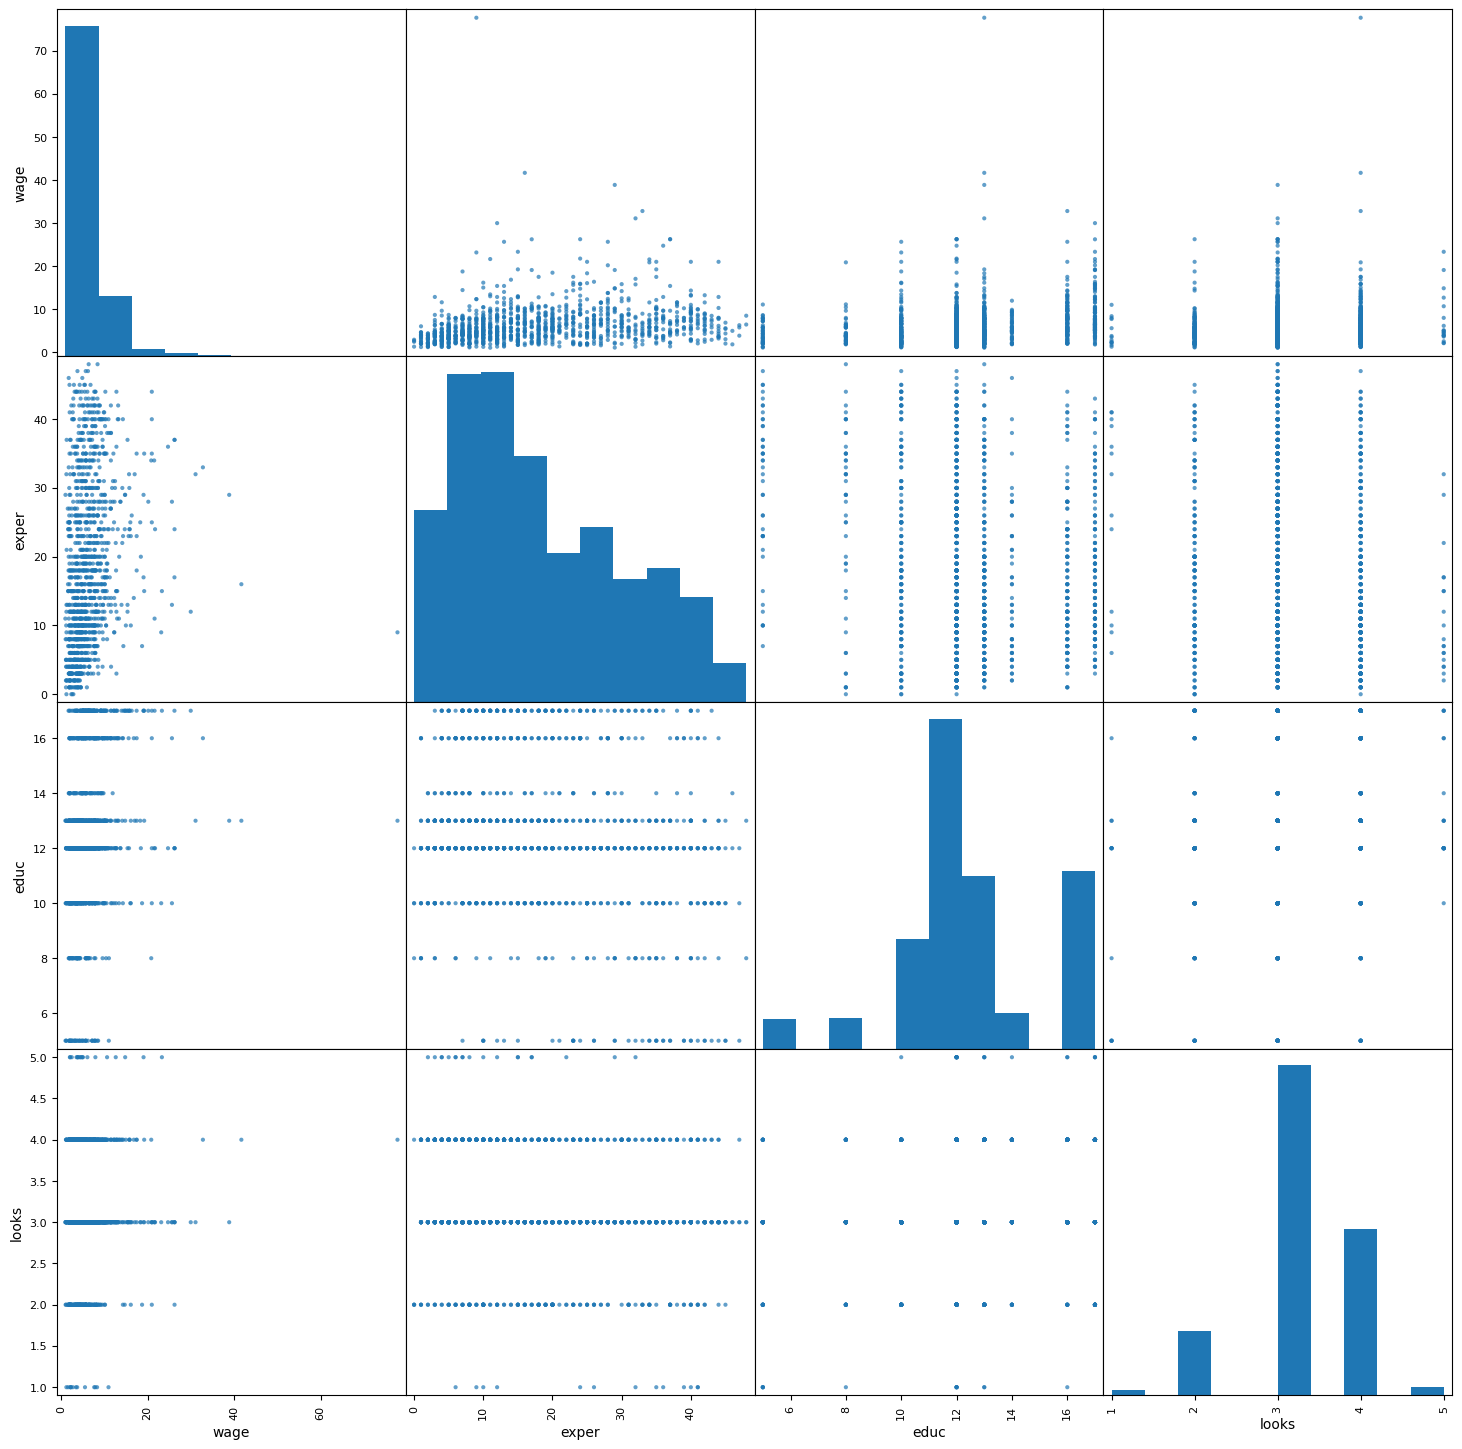

In [5]:
# для количественных признаков выведем матрицу диаграмм рассеяния

pd.plotting.scatter_matrix(data[['wage', 'exper', 'educ', 'looks']], figsize=(18, 18), alpha=0.7)
plt.show()

In [6]:
# а для бинарных признаков просто оценим сбалансированность

print(data.union.value_counts())
print(data.goodhlth.value_counts())
print(data.black.value_counts())
print(data.female.value_counts())
print(data.married.value_counts())
print(data.service.value_counts())

union
0    917
1    343
Name: count, dtype: int64
goodhlth
1    1176
0      84
Name: count, dtype: int64
black
0    1167
1      93
Name: count, dtype: int64
female
0    824
1    436
Name: count, dtype: int64
married
1    871
0    389
Name: count, dtype: int64
service
0    915
1    345
Name: count, dtype: int64


### Предварительная обработка данных

Еще раз посмотрим на целевой признак — уровень заработной платы. 

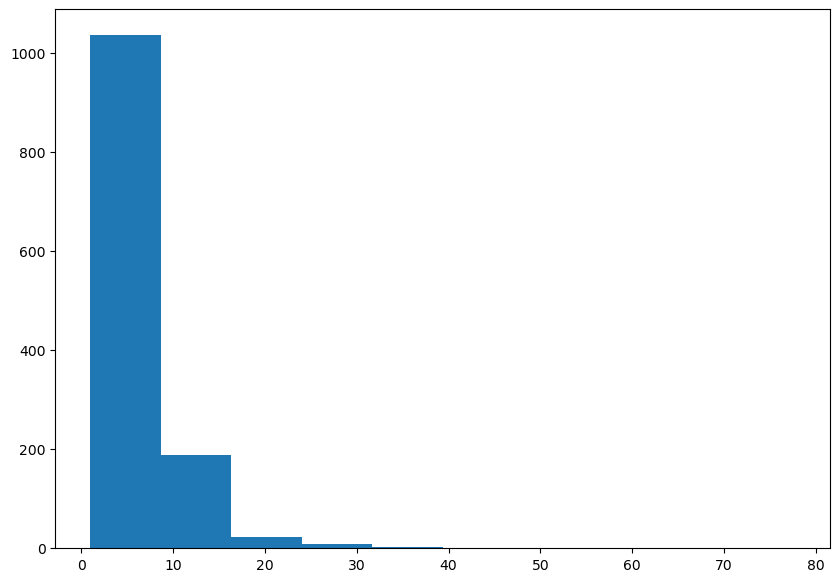

In [7]:
data['wage'].hist(figsize=(10,7), grid=False)
plt.show()

Один человек в выборке получает больше $70\$$ в час, остальные — меньше $50\$$ в час. Это очевидный выброс. Такое наблюдение лучше удалить из выборки, так как иначе регрессия "подстроится" под это наблюдение и будет хуже работать на "типичных" данных. 

In [8]:
data[data['wage'] > 70]

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
602,77.72,9,1,1,1,1,1,1,13,4


In [9]:
data = data[data['wage'] < 70]

<Axes: >

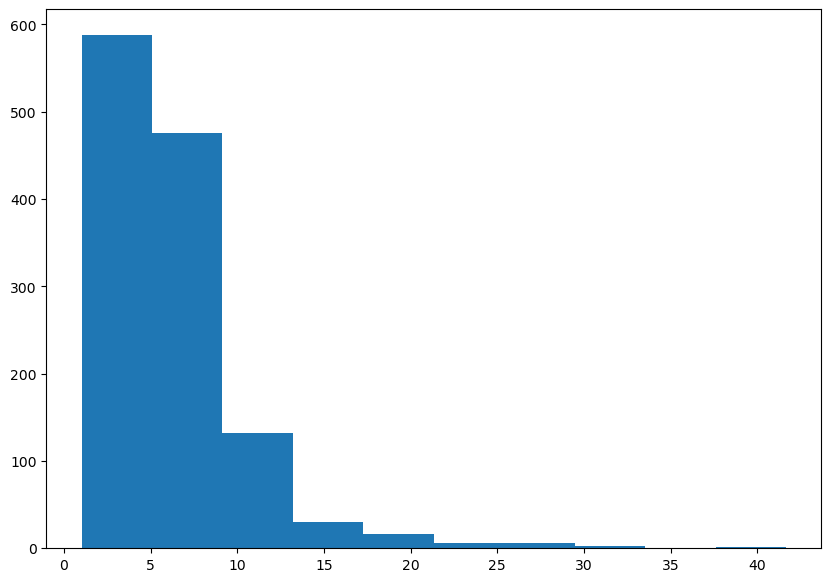

In [12]:
data['wage'].hist(figsize=(10,7), grid=False)

Посмотрим еще на признак, которых характеризует привлекательность опрошенных. 

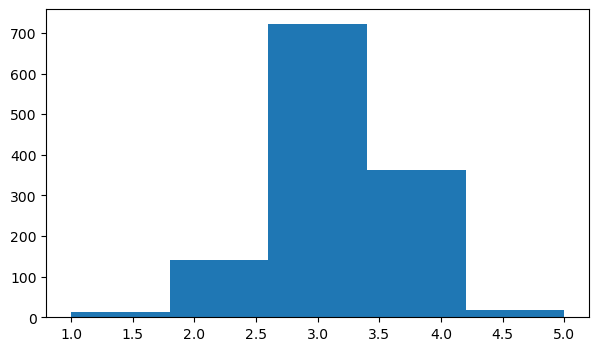

In [10]:
data['looks'].hist(figsize=(7,4), grid=False, bins = 5)
plt.show()

In [13]:
print(data['looks'].value_counts())

looks
3    722
4    363
2    142
5     19
1     13
Name: count, dtype: int64


Видим, что незначительная часть опрошенных получили 1 или 5 баллов за привлекательность. И при этом много опрошенных оказались "средне" привлекательными — получили 3 балла. Так как нам нужно понять, влияет ли привлекательность на уровень заработной платы, заменим признак looks на два бинарных: привлекательность ниже среднего (1 или 2 балла) и  привлекательность выше среднего (4 или 5 баллов).

In [14]:
data['belowavg'] = data['looks'].apply(lambda x: 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x: 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

In [15]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


### Построение и анализ регрессии

In [16]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married + service + educ + belowavg + aboveavg', data=data)
m1fitted = m1.fit()

print(m1fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.42e-75
Time:                        21:42:30   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4

Перед тем, как интерпретировать полученные результаты, посмотрим на распределение остатков и визуально сравним его с нормальным.

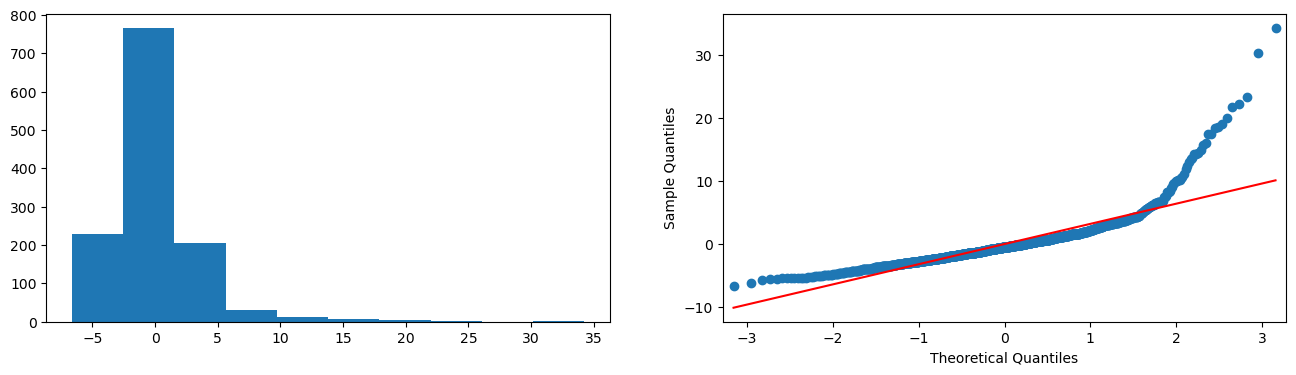

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,4)) 

m1fitted.resid.hist(ax=ax1, grid=False)
qqplot(m1fitted.resid, line='r',ax=ax2)

plt.show()

Распределение остатков имеет тяжелый правый хвост (как, кстати, и распределение заработной платы — нашего отклика). 

### Преобразование признаков

В ситуациях, когда признаки имеют тяжелые хвосты или обладают какими-то другими нежелательными свойствами, часто помогают различные преобразования этих признаков. Давайте, в качестве примера, перейдем от регрессии исходного отклика к регрессии его логарифма.

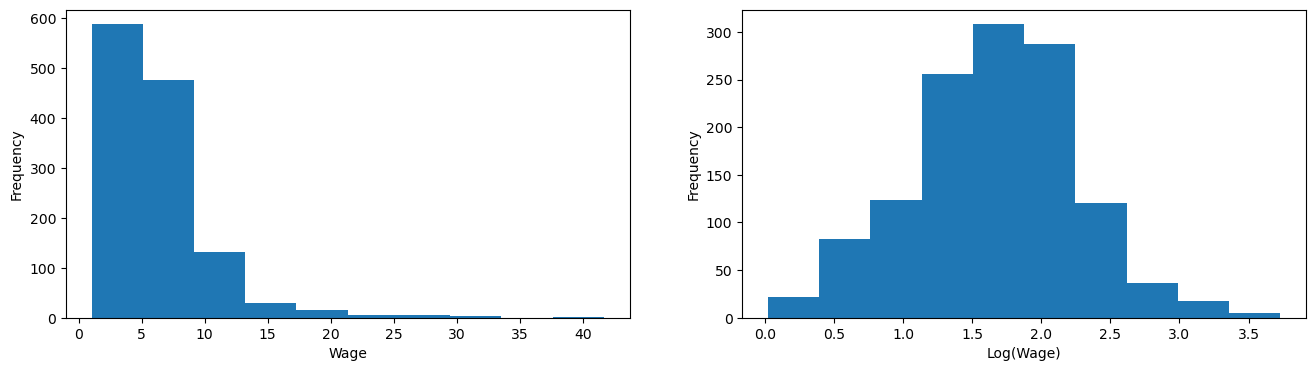

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,4)) 

data['wage'].plot.hist(ax=ax1, grid=False)
ax1.set_xlabel("Wage")

np.log(data['wage']).plot.hist(ax=ax2, grid=False)
ax2.set_xlabel("Log(Wage)")

plt.show()

In [19]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married + service + educ + belowavg + aboveavg', data=data)
m2fitted = m2.fit()

print(m2fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.18e-123
Time:                        21:44:28   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

Снова посмотрим на остатки.

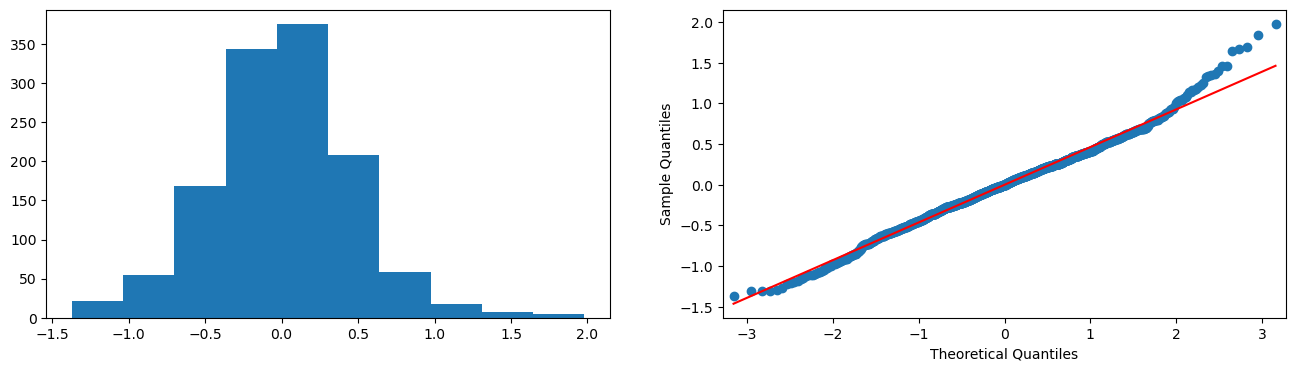

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,4)) 

m2fitted.resid.hist(ax=ax1, grid=False)
qqplot(m2fitted.resid, line='r',ax=ax2)

plt.show()

Ситуация с остатками стала значительно лучше: коэффициент детерминации увеличился, а распределение остатков стало больше напоминать нормальное. Посмотрим на зависимость остатков от непрерывных признаков.

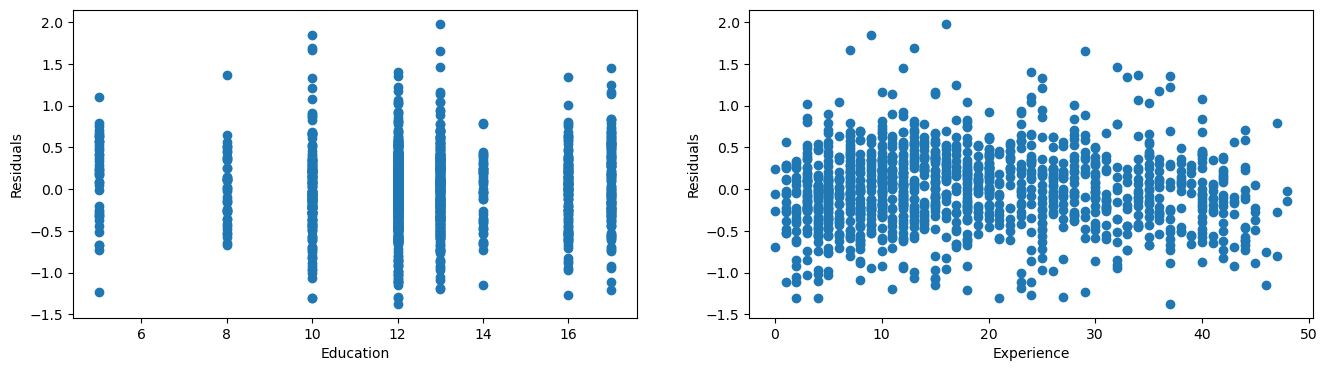

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4)) 

ax1.scatter(data['educ'],m2fitted.resid)
ax1.set_xlabel('Education')
ax1.set_ylabel('Residuals')

ax2.scatter(data['exper'],m2fitted.resid)
ax2.set_xlabel('Experience')
ax2.set_ylabel('Residuals')

plt.show()

По второму графику может показаться, что остатки расположены несимметрично относительно нуля. Так может произойти, например, если зависимость отклика от отпыта работы не является линейной. Посмотрим на эту зависимость повнимательнее. 

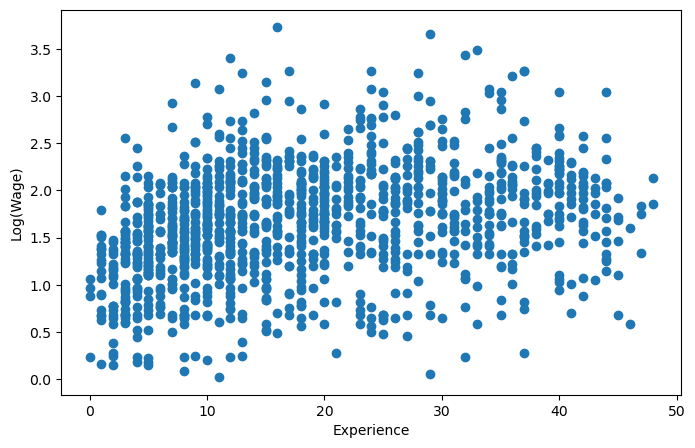

In [22]:
plt.figure(figsize=(8,5))

plt.scatter(data['exper'],np.log(data['wage']))
plt.xlabel('Experience')
plt.ylabel('Log(Wage)')

plt.show()

Действительно, эта зависимость не похожа на линейную. Мы видим, что сначала значения отклика увеличиваются при увеличении опыта работы, но затем увеличение опыта работы перестает влиять на отклик. Может показаться, что зависимость больше напоминает квадратный корень или параболу (малой кривизны). Попробуем добавить к признакам квадратный корень опыта работы, чтобы учесть этот эффект.

### Добавление новых признаков

In [23]:
m3 = smf.ols('np.log(wage) ~ exper + np.sqrt(exper) + union + goodhlth + black + female + married + service + educ + belowavg + aboveavg', data=data)
m3fitted = m3.fit()

print(m3fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     76.33
Date:                Tue, 28 May 2024   Prob (F-statistic):          4.83e-131
Time:                        21:46:50   Log-Likelihood:                -797.28
No. Observations:                1259   AIC:                             1619.
Df Residuals:                    1247   BIC:                             1680.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0091      0.117      0.

Посмотрим на остатки и зависимость остатков от непрерывных признаков.

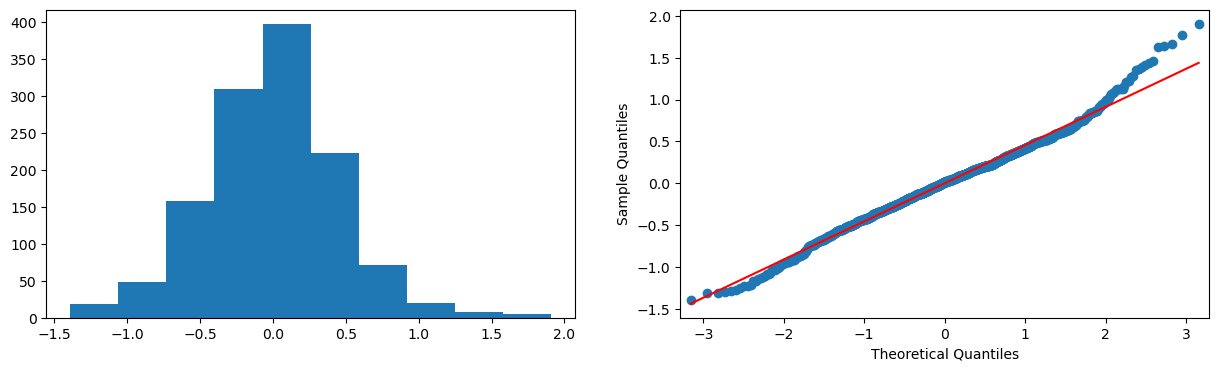

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4)) 

m3fitted.resid.hist(ax=ax1, grid=False)
qqplot(m3fitted.resid, line='r',ax=ax2)

plt.show()

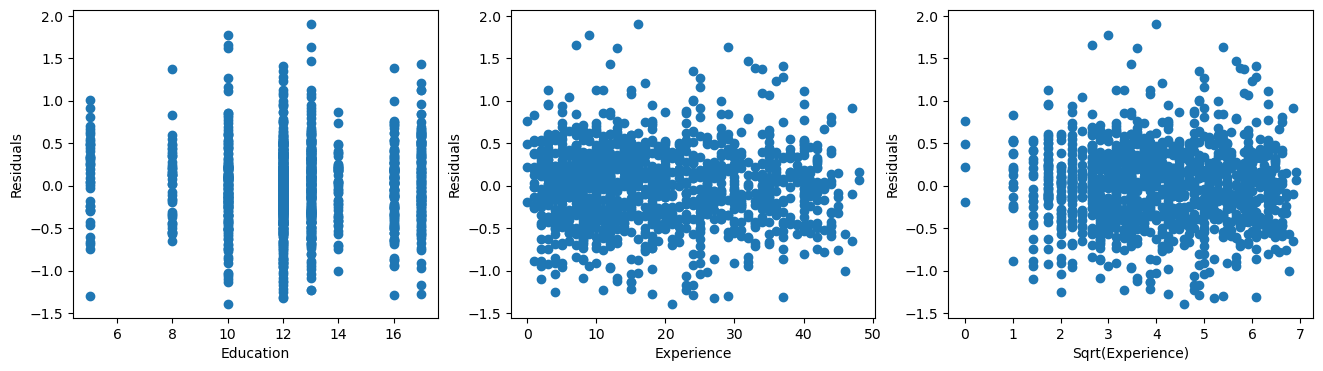

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4)) 

ax1.scatter(data['educ'],m3fitted.resid)
ax1.set_xlabel('Education')
ax1.set_ylabel('Residuals')

ax2.scatter(data['exper'],m3fitted.resid)
ax2.set_xlabel('Experience')
ax2.set_ylabel('Residuals')

ax3.scatter(np.sqrt(data['exper']),m3fitted.resid)
ax3.set_xlabel('Sqrt(Experience)')
ax3.set_ylabel('Residuals')

plt.show()

Заметим, что после добавления нового признака — квадратного корня из опыта работы — ситуация улучшилась: распределение остатков стало более гомоскедастичным и симметричным относительно нуля. Хоть и коэффициент детерминации $R^2$ сильно не изменился, оставим этот признак в нашей модели, так как симметричность и гомоскедастичность ошибок улучшит точность доверительных интервалов для коэффициентов регрессии и проверку гипотез о их значениях (доверительные интервалы и критерии строятся в предположении о нормальности ошибок).

### Удаление ненужных признаков

В модели m3 есть признаки, которые слабо влияют на отклик: состояние здоровья, цвет кожи, семейное положение и Intercept (столбец единиц). Удалим их. Признак aboveavg (привлекательность выше среднего) тоже незначим, но удалять его не будем, так как в данной задаче нам нужно исследовать его влияние на отклик.

In [26]:
m4 = smf.ols('np.log(wage) ~ exper + np.sqrt(exper) + union + female + service + educ + belowavg + aboveavg -1', data=data)
m4fitted = m4.fit()

print(m4fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:           np.log(wage)   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              2162.
Date:                Tue, 28 May 2024   Prob (F-statistic):                        0.00
Time:                        21:48:53   Log-Likelihood:                         -799.63
No. Observations:                1259   AIC:                                      1615.
Df Residuals:                    1251   BIC:                                      1656.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

После удаления четырех признаков коэффициент детерминации $R^2$ значимо изменился, теперь его значение равно $0.933$. Но это ничего не значит, так как без признака Intercept он считается по другой формуле: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.rsquared.html#statsmodels.regression.linear_model.RegressionResults.rsquared 

In [27]:
print(1 - m4fitted.ssr/m4fitted.uncentered_tss)
print(1 - m4fitted.ssr/m4fitted.centered_tss) 

0.9325580236779081
0.4001663906189966


Тем не менее, коэффициент $R^2$, посчитанный по предыдущей формуле, почти не изменился. Это означает, что модель несильно пострадала от удаления признаков.

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,4)) 

m4fitted.resid.hist(ax=ax1, grid=False)
qqplot(m4fitted.resid, line='r',ax=ax2)

plt.show()

### Критерий Фишера

Посмотрим с помощью критерия Фишера, не стала ли модель m4 хуже m3 после удаления четырех признаков.

In [ ]:
# первый способ

print("F=%f, pvalue=%f, k1=%f" % m3fitted.compare_f_test(m4fitted))

In [ ]:
# второй способ способ

m3fitted.f_test("Intercept = goodhlth = black = married = 0")

Видим, что гипотеза "Intercept = goodhlth = black = married = 0" не отвергается, что окончательно убеждает нас в том, что модель m4 лучше, чем m3. (Конечно, этот критерий тоже требует нормальность ошибок, которой у нас нет, тем не менее мы пользуемся принципом: "идеальные условия никогда не выполняются, но модели, которые мы строим и которые требуют выполнения этих идеальных условий, часто бывают полезными".)

### Еще одна визуальная проверка

Еще один способ визуально проверить регрессионную модель, является следующий график. На нем отображена зависимость "влиятельности" каждого наблюдения от квадрата соответствующего остатка (квадрата ошибки предсказания модели). Подробнее о том, как считается "влиятельность" можно посмотреть здесь: https://en.wikipedia.org/wiki/Leverage_(statistics)

In [ ]:
plt.rc("figure", figsize=(16,8))
plot_leverage_resid2(m4fitted)
plt.show()

In [ ]:
data.loc[[269]]

In [ ]:
data.loc[[878]]

В целом, на этом графике все хорошо — мы не видим очевидных выбросов. Можно, конечно, попытаться удалить точки, на которых наша модель сильно ошибается (примеры выше), но не совсем очевидно, поэтому это сделает нашу модель лучше.

### Вывод

Итоговая модель m4 достаточно хороша, она объясняет примерно $40\%$ вариации отклика — логарифма заработной платы. 
Она выглядит следующим образом: 

$$
\log(\text{wage}) \approx 
-0.0244 \cdot \text{exper} + 0.3185  \cdot \sqrt{\text{exper}}
+0.1719 \cdot \text{union} -0.4013 \cdot \text{female}
-0.1616 \cdot \text{service} +0.0777 \cdot \text{educ}\\
-0.1210 \cdot \text{belowavg}  -0.0021 \cdot \text{aboveavg}.
$$
  
Это можно записать в следующем виде: 

$$
\text{wage} \approx  e^{-0.0244 \text{exper}} \cdot e^{0.3185 \sqrt{\text{exper}}}
\cdot e^{+0.1719 \text{union}} \cdot e^{-0.4013 \text{female}}
\cdot e^{-0.1616 \text{service}} \cdot e^{0.0777 \text{educ}}
\cdot e^{-0.1210 \text{belowavg}} \cdot e^{ -0.0021\text{aboveavg}}.
$$


При интересующих нас признаках привлекательности стоят коэффициенты: -0.1210 (при belowavg) и -0.0021 (при aboveavg). Поскольку регрессия делалась на логарифм заработной платы, интерпретировать их можно как прирост в процентах ($e^{\beta} \approx 1 + \beta$). То есть представители генеральной совокупности, из которой взята выборка, получают в среднем:

* на 12% меньше, если их привлекательность ниже среднего;
* столько же, если их привлекательность выше среднего.

### П.С. Предсказание

Как мы уже говорили, регрессионные модели часто стоятся для предсказания отклика на новых признаках. 

In [ ]:
data.head(1)

Построим предсказание для наблюдения выше в случае, если бы у этого человека было бы 10 лет образования, но 34 года опыта работы.

In [ ]:
point = data.iloc[0,1:]
point['exper'] = 34
point['educ'] = 10
point

In [ ]:
# так как в модели откликом являлась не заработная плата, а ее логарифм, 
# то функция predict вернет предсказанное значение для логарифма

logwage_predicted = m4fitted.predict(point)

In [ ]:
# а так получим предсказание для самой заработной платы

wage_predicted = np.exp(logwage_predicted)

In [ ]:
print("Заработная плата будет равна: ", wage_predicted.values[0])